In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, precision_score
from xgboost import XGBClassifier
from scripts.csv_continue_to_ds_discreet import csvContinue2DSDiscreet
from scripts.evaluate_model import evaluate_predictions

In [2]:
X, y = csvContinue2DSDiscreet()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [4]:
ratio = sum(y_train == 0) / sum(y_train == 1)

model_1 = Pipeline([
  ('xgboost', XGBClassifier(random_state=0, scale_pos_weight=ratio))
])

In [5]:
params = {
  'xgboost__n_estimators': [50, 100, 150],
  'xgboost__learning_rate': [0.01, 0.02, 0.05],
  'xgboost__max_depth': [5, 10]
}

cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(model_1, param_grid=params, cv=cv_stratified, scoring='roc_auc', n_jobs=-1)

In [6]:
gs

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgboost__learning_rate': [0.01, 0.02, ...], 'xgboost__max_depth': [5, 10], 'xgboost__n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [7]:
gs.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgboost__learning_rate': [0.01, 0.02, ...], 'xgboost__max_depth': [5, 10], 'xgboost__n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [8]:
(f'best_score: {gs.best_score_}; best_params: {gs.best_params_}')

"best_score: 0.8625536319305912; best_params: {'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 100}"

In [9]:
results = pd.DataFrame(gs.cv_results_)

In [19]:
def evaluate_on_train_test_ensemble(model, X_train, y_train, X_test, y_test):
    print(f"Evaluating train data")
    train_predictions = model.predict(X_train)
    train_probas = model.predict_proba(X_train)
    evaluate_predictions(train_predictions, y_train, train_probas[:, 1])
    
    print("Evaluating on test data")
    
    test_predictions = model.predict(X_test)
    test_probas = model.predict_proba(X_test)
    evaluate_predictions(test_predictions, y_test, test_probas[:, 1])


In [11]:
X.columns

Index(['age_is_null', 'isChild', 'isTeen', 'isAdult', 'isSenior', 'isOld',
       'IsAlone', 'IsSmallFamily', 'IsBigFamily', 'FirstClass', 'SecondClass',
       'ThirdClass', 'EmbarkedS', 'EmbarkedC', 'EmbarkedQ', 'Male'],
      dtype='object')

Evaluating train data


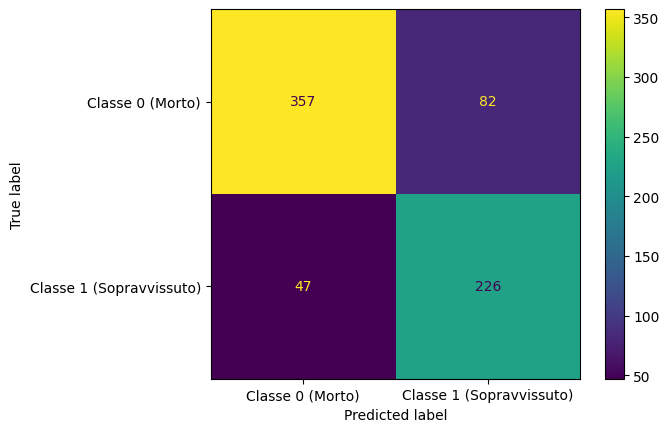

Percentuale di veri negativi: 81.32%
Percentuale di veri positivi: 82.78%
                          precision    recall  f1-score   support

        Classe 0 (Morto)       0.88      0.81      0.85       439
Classe 1 (Sopravvissuto)       0.73      0.83      0.78       273

                accuracy                           0.82       712
               macro avg       0.81      0.82      0.81       712
            weighted avg       0.83      0.82      0.82       712

[[357  82]
 [ 47 226]]


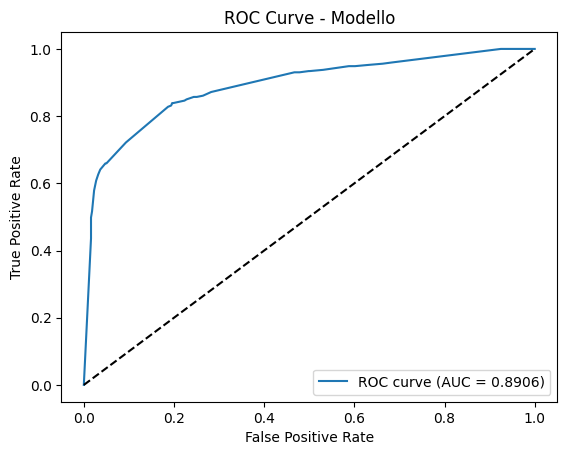

Evaluating on test data


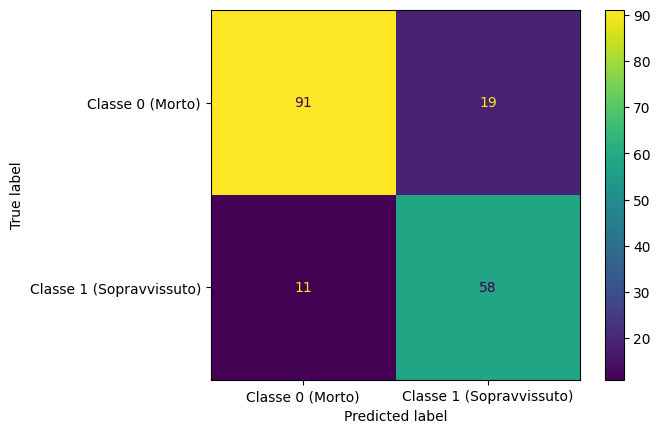

Percentuale di veri negativi: 82.73%
Percentuale di veri positivi: 84.06%
                          precision    recall  f1-score   support

        Classe 0 (Morto)       0.89      0.83      0.86       110
Classe 1 (Sopravvissuto)       0.75      0.84      0.79        69

                accuracy                           0.83       179
               macro avg       0.82      0.83      0.83       179
            weighted avg       0.84      0.83      0.83       179

[[91 19]
 [11 58]]


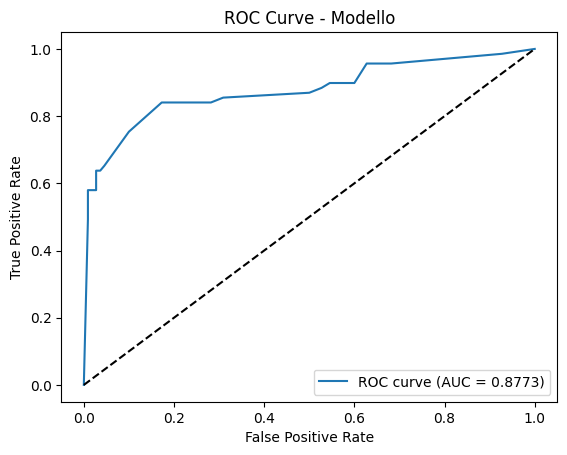

In [20]:
evaluate_on_train_test_ensemble(gs.best_estimator_, X_train, y_train, X_test, y_test)